# DC-TSS Example with PAMAP2 

In [44]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets


import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from TS_DEC import *
#from TS_DEC_Linear import *


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance
from typing import Optional, List
from scipy.io import arff

from scipy.signal import find_peaks

## Set Parameters

In [51]:
# Hyper parameters for Neural Network
epochs1 = 1200
epochs2 = 8000
lr=0.08
pre_lr = 1.5e-2
layers = [16,8,4]
strides = [3,3,3]

# DC-TSS hyper-parameters
window_length = 160
overlap_percent = 0.3
n_clusters = 70
window_length2 = 50



## Read Dataset

In [52]:
#selected_songs = [2,140,30056,30058,85594,120308,120194,120112,120105]
time_series = np.loadtxt("./data/PAMAP2.csv", delimiter=",")
labels = np.loadtxt("./data/PAMAP2_labels.csv", delimiter=",")
ground_truth = np.where(labels[:-1] != labels[1:])[0]


## Subsequence TS

In [53]:
start = 0
subsequences = []
subsequence_labels = []

while start+window_length < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
    subsequence = time_series[:,start:start+window_length]
    start = start+window_length - int(overlap_percent*window_length)
    subsequences.append(subsequence)

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)
batch_size = subsequences.shape[0]

C:\Users\Erik\AppData\Local\Temp\ipykernel_37984\358066657.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


## Set Data_loader for Neural Network?

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


data_loader = get_dataloader(data=subsequences,
                          batch_size=batch_size,
                          num_workers=1,
                          data_transforms=None)
torch.cuda.empty_cache()
input_shape = subsequences.shape
#torch.cuda.memory_summary(device=None, abbreviated=False)



cuda


## Create DC-TSS model

In [55]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.to(device)


DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(40, 40, kernel_size=(16,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(40, 40, kernel_size=(4,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(40, 40, kernel_size=(4,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(40, 40, kernel_size=(16,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      (0): Conv1d(40, 40, kernel_size=(16,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Con

## Phase 1: Initialize Latent Space Mapping with 1DCNN AE

In [56]:
pretraining(model=deep_cluster_model, dbgenerator=data_loader, batch_size=batch_size, epochs=epochs1)


epoch 1,loss = 0.99949741
epoch 2,loss = 0.99947256
epoch 3,loss = 0.99944884
epoch 4,loss = 0.99942559
epoch 5,loss = 0.99940199
epoch 6,loss = 0.99937725
epoch 7,loss = 0.99935097
epoch 8,loss = 0.99932337
epoch 9,loss = 0.99929345
epoch 10,loss = 0.99926025
epoch 11,loss = 0.99922341
epoch 12,loss = 0.99918181
epoch 13,loss = 0.99913496
epoch 14,loss = 0.99908203
epoch 15,loss = 0.99902129
epoch 16,loss = 0.99895108
epoch 17,loss = 0.99887127
epoch 18,loss = 0.99877900
epoch 19,loss = 0.99867207
epoch 20,loss = 0.99854910
epoch 21,loss = 0.99840790
epoch 22,loss = 0.99824458
epoch 23,loss = 0.99805707
epoch 24,loss = 0.99784064
epoch 25,loss = 0.99759030
epoch 26,loss = 0.99730039
epoch 27,loss = 0.99696642
epoch 28,loss = 0.99657911
epoch 29,loss = 0.99612993
epoch 30,loss = 0.99560982
epoch 31,loss = 0.99500632
epoch 32,loss = 0.99430615
epoch 33,loss = 0.99349922
epoch 34,loss = 0.99256903
epoch 35,loss = 0.99149513
epoch 36,loss = 0.99026233
epoch 37,loss = 0.98884916
epoch 38,l

epoch 298,loss = 0.61550391
epoch 299,loss = 0.61464864
epoch 300,loss = 0.61379790
epoch 301,loss = 0.61295128
epoch 302,loss = 0.61210930
epoch 303,loss = 0.61127073
epoch 304,loss = 0.61043561
epoch 305,loss = 0.60960376
epoch 306,loss = 0.60877538
epoch 307,loss = 0.60795158
epoch 308,loss = 0.60713196
epoch 309,loss = 0.60631865
epoch 310,loss = 0.60551202
epoch 311,loss = 0.60471421
epoch 312,loss = 0.60392296
epoch 313,loss = 0.60313749
epoch 314,loss = 0.60235631
epoch 315,loss = 0.60157776
epoch 316,loss = 0.60080206
epoch 317,loss = 0.60002881
epoch 318,loss = 0.59925938
epoch 319,loss = 0.59849435
epoch 320,loss = 0.59773487
epoch 321,loss = 0.59698105
epoch 322,loss = 0.59623295
epoch 323,loss = 0.59549171
epoch 324,loss = 0.59475648
epoch 325,loss = 0.59402442
epoch 326,loss = 0.59328842
epoch 327,loss = 0.59254700
epoch 328,loss = 0.59181279
epoch 329,loss = 0.59109116
epoch 330,loss = 0.59037668
epoch 331,loss = 0.58966088
epoch 332,loss = 0.58893836
epoch 333,loss = 0.5

epoch 591,loss = 0.46574971
epoch 592,loss = 0.46547037
epoch 593,loss = 0.46518308
epoch 594,loss = 0.46490037
epoch 595,loss = 0.46462777
epoch 596,loss = 0.46436611
epoch 597,loss = 0.46411094
epoch 598,loss = 0.46385685
epoch 599,loss = 0.46360141
epoch 600,loss = 0.46334234
epoch 601,loss = 0.46308166
epoch 602,loss = 0.46281639
epoch 603,loss = 0.46255031
epoch 604,loss = 0.46227920
epoch 605,loss = 0.46200982
epoch 606,loss = 0.46173921
epoch 607,loss = 0.46147141
epoch 608,loss = 0.46120614
epoch 609,loss = 0.46094298
epoch 610,loss = 0.46068150
epoch 611,loss = 0.46042153
epoch 612,loss = 0.46016243
epoch 613,loss = 0.45990494
epoch 614,loss = 0.45964882
epoch 615,loss = 0.45939639
epoch 616,loss = 0.45915061
epoch 617,loss = 0.45891511
epoch 618,loss = 0.45869932
epoch 619,loss = 0.45850822
epoch 620,loss = 0.45836458
epoch 621,loss = 0.45822406
epoch 622,loss = 0.45807999
epoch 623,loss = 0.45773652
epoch 624,loss = 0.45730022
epoch 625,loss = 0.45689443
epoch 626,loss = 0.4

epoch 884,loss = 0.41080990
epoch 885,loss = 0.41068229
epoch 886,loss = 0.41055110
epoch 887,loss = 0.41041693
epoch 888,loss = 0.41027892
epoch 889,loss = 0.41014174
epoch 890,loss = 0.41000649
epoch 891,loss = 0.40987435
epoch 892,loss = 0.40974441
epoch 893,loss = 0.40961710
epoch 894,loss = 0.40949124
epoch 895,loss = 0.40936664
epoch 896,loss = 0.40924209
epoch 897,loss = 0.40911624
epoch 898,loss = 0.40899345
epoch 899,loss = 0.40887350
epoch 900,loss = 0.40876666
epoch 901,loss = 0.40866983
epoch 902,loss = 0.40859923
epoch 903,loss = 0.40853706
epoch 904,loss = 0.40850386
epoch 905,loss = 0.40843201
epoch 906,loss = 0.40833649
epoch 907,loss = 0.40811992
epoch 908,loss = 0.40785193
epoch 909,loss = 0.40759194
epoch 910,loss = 0.40742466
epoch 911,loss = 0.40735412
epoch 912,loss = 0.40731660
epoch 913,loss = 0.40723819
epoch 914,loss = 0.40707123
epoch 915,loss = 0.40687034
epoch 916,loss = 0.40669140
epoch 917,loss = 0.40656883
epoch 918,loss = 0.40648603
epoch 919,loss = 0.4

epoch 1171,loss = 0.37987778
epoch 1172,loss = 0.37978724
epoch 1173,loss = 0.37969926
epoch 1174,loss = 0.37960687
epoch 1175,loss = 0.37951279
epoch 1176,loss = 0.37941691
epoch 1177,loss = 0.37932160
epoch 1178,loss = 0.37922549
epoch 1179,loss = 0.37913114
epoch 1180,loss = 0.37903953
epoch 1181,loss = 0.37894881
epoch 1182,loss = 0.37885642
epoch 1183,loss = 0.37876326
epoch 1184,loss = 0.37866902
epoch 1185,loss = 0.37857571
epoch 1186,loss = 0.37848696
epoch 1187,loss = 0.37840223
epoch 1188,loss = 0.37832114
epoch 1189,loss = 0.37824100
epoch 1190,loss = 0.37816128
epoch 1191,loss = 0.37808067
epoch 1192,loss = 0.37799883
epoch 1193,loss = 0.37791905
epoch 1194,loss = 0.37784109
epoch 1195,loss = 0.37776518
epoch 1196,loss = 0.37769395
epoch 1197,loss = 0.37762353
epoch 1198,loss = 0.37756351
epoch 1199,loss = 0.37750354
epoch 1200,loss = 0.37746802


## Phase 2: Refine Latent Space and Find Clusters

In [57]:
cluster_assignments = refine_clusters(n_clusters, data_loader, deep_cluster_model, device, epochs2, batch_size, lr, 0.8, 1)


Initializing cluster centers with k-means. number of clusters 70
torch.Size([3360, 40, 160])
1.0
Epoch 1:   loss= 0.42744
Epoch 2:   loss= 0.42708
Epoch 3:   loss= 0.42673
Epoch 4:   loss= 0.42654
Epoch 5:   loss= 0.42649
Epoch 6:   loss= 0.42651
Epoch 7:   loss= 0.4266
Epoch 8:   loss= 0.42668
Epoch 9:   loss= 0.42674
Epoch 10:   loss= 0.42676
Epoch 11:   loss= 0.42673
Epoch 12:   loss= 0.42665
Epoch 13:   loss= 0.42652
Epoch 14:   loss= 0.42637
Epoch 15:   loss= 0.4262
Epoch 16:   loss= 0.42601
Epoch 17:   loss= 0.4258
Epoch 18:   loss= 0.4256
Epoch 19:   loss= 0.42538
Epoch 20:   loss= 0.42516
Epoch 21:   loss= 0.42495
Epoch 22:   loss= 0.42473
Epoch 23:   loss= 0.42451
Epoch 24:   loss= 0.4243
Epoch 25:   loss= 0.42409
Epoch 26:   loss= 0.42388
Epoch 27:   loss= 0.42367
Epoch 28:   loss= 0.42347
Epoch 29:   loss= 0.42327
Epoch 30:   loss= 0.42308
Epoch 31:   loss= 0.42289
Epoch 32:   loss= 0.42271
Epoch 33:   loss= 0.42253
Epoch 34:   loss= 0.42236
Epoch 35:   loss= 0.42219
Epoch 3

Epoch 312:   loss= 0.39528
Epoch 313:   loss= 0.39519
Epoch 314:   loss= 0.3951
Epoch 315:   loss= 0.39501
Epoch 316:   loss= 0.39493
Epoch 317:   loss= 0.39484
Epoch 318:   loss= 0.39476
Epoch 319:   loss= 0.39467
Epoch 320:   loss= 0.39458
Epoch 321:   loss= 0.3945
Epoch 322:   loss= 0.39441
Epoch 323:   loss= 0.39433
Epoch 324:   loss= 0.39425
Epoch 325:   loss= 0.39417
Epoch 326:   loss= 0.39409
Epoch 327:   loss= 0.39402
Epoch 328:   loss= 0.39395
Epoch 329:   loss= 0.39388
Epoch 330:   loss= 0.39382
Epoch 331:   loss= 0.39376
Epoch 332:   loss= 0.3937
Epoch 333:   loss= 0.39364
Epoch 334:   loss= 0.39357
Epoch 335:   loss= 0.3935
Epoch 336:   loss= 0.39343
Epoch 337:   loss= 0.39336
Epoch 338:   loss= 0.39329
Epoch 339:   loss= 0.39322
Epoch 340:   loss= 0.39315
Epoch 341:   loss= 0.39308
Epoch 342:   loss= 0.39301
Epoch 343:   loss= 0.39294
Epoch 344:   loss= 0.39287
Epoch 345:   loss= 0.3928
Epoch 346:   loss= 0.39273
Epoch 347:   loss= 0.39267
Epoch 348:   loss= 0.3926
Epoch 3

Epoch 617:   loss= 0.37804
Epoch 618:   loss= 0.378
Epoch 619:   loss= 0.37796
Epoch 620:   loss= 0.37792
Epoch 621:   loss= 0.37788
Epoch 622:   loss= 0.37784
Epoch 623:   loss= 0.3778
Epoch 624:   loss= 0.37776
Epoch 625:   loss= 0.37772
Epoch 626:   loss= 0.37768
Epoch 627:   loss= 0.37764
Epoch 628:   loss= 0.3776
Epoch 629:   loss= 0.37755
Epoch 630:   loss= 0.37751
Epoch 631:   loss= 0.37747
Epoch 632:   loss= 0.37743
Epoch 633:   loss= 0.37739
Epoch 634:   loss= 0.37735
Epoch 635:   loss= 0.37731
Epoch 636:   loss= 0.37727
Epoch 637:   loss= 0.37723
Epoch 638:   loss= 0.37719
Epoch 639:   loss= 0.37715
Epoch 640:   loss= 0.37711
Epoch 641:   loss= 0.37707
Epoch 642:   loss= 0.37703
Epoch 643:   loss= 0.37699
Epoch 644:   loss= 0.37695
Epoch 645:   loss= 0.37691
Epoch 646:   loss= 0.37688
Epoch 647:   loss= 0.37684
Epoch 648:   loss= 0.3768
Epoch 649:   loss= 0.37676
Epoch 650:   loss= 0.37672
Epoch 651:   loss= 0.37668
Epoch 652:   loss= 0.37664
Epoch 653:   loss= 0.3766
Epoch 6

Epoch 923:   loss= 0.36785
Epoch 924:   loss= 0.36783
Epoch 925:   loss= 0.3678
Epoch 926:   loss= 0.36777
Epoch 927:   loss= 0.36775
Epoch 928:   loss= 0.36772
Epoch 929:   loss= 0.36769
Epoch 930:   loss= 0.36767
Epoch 931:   loss= 0.36764
Epoch 932:   loss= 0.36762
Epoch 933:   loss= 0.36759
Epoch 934:   loss= 0.36756
Epoch 935:   loss= 0.36754
Epoch 936:   loss= 0.36751
Epoch 937:   loss= 0.36748
Epoch 938:   loss= 0.36746
Epoch 939:   loss= 0.36743
Epoch 940:   loss= 0.36741
Epoch 941:   loss= 0.36738
Epoch 942:   loss= 0.36736
Epoch 943:   loss= 0.36733
Epoch 944:   loss= 0.3673
Epoch 945:   loss= 0.36728
Epoch 946:   loss= 0.36725
Epoch 947:   loss= 0.36723
Epoch 948:   loss= 0.3672
Epoch 949:   loss= 0.36717
Epoch 950:   loss= 0.36715
Epoch 951:   loss= 0.36712
Epoch 952:   loss= 0.3671
Epoch 953:   loss= 0.36707
Epoch 954:   loss= 0.36705
Epoch 955:   loss= 0.36702
Epoch 956:   loss= 0.367
Epoch 957:   loss= 0.36697
Epoch 958:   loss= 0.36694
Epoch 959:   loss= 0.36692
Epoch 9

Epoch 1225:   loss= 0.36106
Epoch 1226:   loss= 0.36104
Epoch 1227:   loss= 0.36102
Epoch 1228:   loss= 0.361
Epoch 1229:   loss= 0.36099
Epoch 1230:   loss= 0.36097
Epoch 1231:   loss= 0.36095
Epoch 1232:   loss= 0.36093
Epoch 1233:   loss= 0.36091
Epoch 1234:   loss= 0.36089
Epoch 1235:   loss= 0.36087
Epoch 1236:   loss= 0.36085
Epoch 1237:   loss= 0.36084
Epoch 1238:   loss= 0.36082
Epoch 1239:   loss= 0.3608
Epoch 1240:   loss= 0.36078
Epoch 1241:   loss= 0.36076
Epoch 1242:   loss= 0.36074
Epoch 1243:   loss= 0.36072
Epoch 1244:   loss= 0.3607
Epoch 1245:   loss= 0.36069
Epoch 1246:   loss= 0.36067
Epoch 1247:   loss= 0.36065
Epoch 1248:   loss= 0.36063
Epoch 1249:   loss= 0.36061
Epoch 1250:   loss= 0.36059
Epoch 1251:   loss= 0.36057
Epoch 1252:   loss= 0.36055
Epoch 1253:   loss= 0.36054
Epoch 1254:   loss= 0.36052
Epoch 1255:   loss= 0.3605
Epoch 1256:   loss= 0.36048
Epoch 1257:   loss= 0.36046
Epoch 1258:   loss= 0.36045
Epoch 1259:   loss= 0.36043
Epoch 1260:   loss= 0.360

Epoch 1525:   loss= 0.35632
Epoch 1526:   loss= 0.35631
Epoch 1527:   loss= 0.35629
Epoch 1528:   loss= 0.35628
Epoch 1529:   loss= 0.35627
Epoch 1530:   loss= 0.35625
Epoch 1531:   loss= 0.35624
Epoch 1532:   loss= 0.35622
Epoch 1533:   loss= 0.35621
Epoch 1534:   loss= 0.3562
Epoch 1535:   loss= 0.35618
Epoch 1536:   loss= 0.35617
Epoch 1537:   loss= 0.35616
Epoch 1538:   loss= 0.35615
Epoch 1539:   loss= 0.35614
Epoch 1540:   loss= 0.35612
Epoch 1541:   loss= 0.35611
Epoch 1542:   loss= 0.3561
Epoch 1543:   loss= 0.35609
Epoch 1544:   loss= 0.35608
Epoch 1545:   loss= 0.35606
Epoch 1546:   loss= 0.35605
Epoch 1547:   loss= 0.35604
Epoch 1548:   loss= 0.35602
Epoch 1549:   loss= 0.35601
Epoch 1550:   loss= 0.356
Epoch 1551:   loss= 0.35599
Epoch 1552:   loss= 0.35597
Epoch 1553:   loss= 0.35596
Epoch 1554:   loss= 0.35594
Epoch 1555:   loss= 0.35593
Epoch 1556:   loss= 0.35592
Epoch 1557:   loss= 0.3559
Epoch 1558:   loss= 0.35589
Epoch 1559:   loss= 0.35587
Epoch 1560:   loss= 0.355

Epoch 1821:   loss= 0.3526
Epoch 1822:   loss= 0.35259
Epoch 1823:   loss= 0.35258
Epoch 1824:   loss= 0.35257
Epoch 1825:   loss= 0.35256
Epoch 1826:   loss= 0.35255
Epoch 1827:   loss= 0.35254
Epoch 1828:   loss= 0.35252
Epoch 1829:   loss= 0.35251
Epoch 1830:   loss= 0.3525
Epoch 1831:   loss= 0.35249
Epoch 1832:   loss= 0.35248
Epoch 1833:   loss= 0.35246
Epoch 1834:   loss= 0.35245
Epoch 1835:   loss= 0.35244
Epoch 1836:   loss= 0.35243
Epoch 1837:   loss= 0.35242
Epoch 1838:   loss= 0.35241
Epoch 1839:   loss= 0.3524
Epoch 1840:   loss= 0.35239
Epoch 1841:   loss= 0.35237
Epoch 1842:   loss= 0.35236
Epoch 1843:   loss= 0.35235
Epoch 1844:   loss= 0.35234
Epoch 1845:   loss= 0.35233
Epoch 1846:   loss= 0.35232
Epoch 1847:   loss= 0.35231
Epoch 1848:   loss= 0.3523
Epoch 1849:   loss= 0.35228
Epoch 1850:   loss= 0.35227
Epoch 1851:   loss= 0.35226
Epoch 1852:   loss= 0.35225
Epoch 1853:   loss= 0.35224
Epoch 1854:   loss= 0.35223
Epoch 1855:   loss= 0.35221
Epoch 1856:   loss= 0.35

Epoch 2115:   loss= 0.34946
Epoch 2116:   loss= 0.34946
Epoch 2117:   loss= 0.34945
Epoch 2118:   loss= 0.34944
Epoch 2119:   loss= 0.34943
Epoch 2120:   loss= 0.34942
Epoch 2121:   loss= 0.34941
Epoch 2122:   loss= 0.3494
Epoch 2123:   loss= 0.34939
Epoch 2124:   loss= 0.34938
Epoch 2125:   loss= 0.34937
Epoch 2126:   loss= 0.34936
Epoch 2127:   loss= 0.34935
Epoch 2128:   loss= 0.34934
Epoch 2129:   loss= 0.34933
Epoch 2130:   loss= 0.34932
Epoch 2131:   loss= 0.34931
Epoch 2132:   loss= 0.3493
Epoch 2133:   loss= 0.34929
Epoch 2134:   loss= 0.34928
Epoch 2135:   loss= 0.34927
Epoch 2136:   loss= 0.34926
Epoch 2137:   loss= 0.34925
Epoch 2138:   loss= 0.34925
Epoch 2139:   loss= 0.34924
Epoch 2140:   loss= 0.34923
Epoch 2141:   loss= 0.34922
Epoch 2142:   loss= 0.34921
Epoch 2143:   loss= 0.34921
Epoch 2144:   loss= 0.3492
Epoch 2145:   loss= 0.34919
Epoch 2146:   loss= 0.34918
Epoch 2147:   loss= 0.34917
Epoch 2148:   loss= 0.34916
Epoch 2149:   loss= 0.34915
Epoch 2150:   loss= 0.3

Epoch 2410:   loss= 0.34692
Epoch 2411:   loss= 0.34691
Epoch 2412:   loss= 0.3469
Epoch 2413:   loss= 0.34689
Epoch 2414:   loss= 0.34689
Epoch 2415:   loss= 0.34688
Epoch 2416:   loss= 0.34687
Epoch 2417:   loss= 0.34686
Epoch 2418:   loss= 0.34685
Epoch 2419:   loss= 0.34684
Epoch 2420:   loss= 0.34683
Epoch 2421:   loss= 0.34682
Epoch 2422:   loss= 0.34681
Epoch 2423:   loss= 0.3468
Epoch 2424:   loss= 0.3468
Epoch 2425:   loss= 0.34679
Epoch 2426:   loss= 0.34679
Epoch 2427:   loss= 0.34678
Epoch 2428:   loss= 0.34678
Epoch 2429:   loss= 0.34677
Epoch 2430:   loss= 0.34676
Epoch 2431:   loss= 0.34675
Epoch 2432:   loss= 0.34674
Epoch 2433:   loss= 0.34674
Epoch 2434:   loss= 0.34673
Epoch 2435:   loss= 0.34672
Epoch 2436:   loss= 0.34672
Epoch 2437:   loss= 0.34671
Epoch 2438:   loss= 0.3467
Epoch 2439:   loss= 0.3467
Epoch 2440:   loss= 0.34669
Epoch 2441:   loss= 0.34668
Epoch 2442:   loss= 0.34667
Epoch 2443:   loss= 0.34667
Epoch 2444:   loss= 0.34666
Epoch 2445:   loss= 0.346

Epoch 2705:   loss= 0.34477
Epoch 2706:   loss= 0.34476
Epoch 2707:   loss= 0.34476
Epoch 2708:   loss= 0.34475
Epoch 2709:   loss= 0.34475
Epoch 2710:   loss= 0.34474
Epoch 2711:   loss= 0.34473
Epoch 2712:   loss= 0.34473
Epoch 2713:   loss= 0.34472
Epoch 2714:   loss= 0.34471
Epoch 2715:   loss= 0.34471
Epoch 2716:   loss= 0.3447
Epoch 2717:   loss= 0.34469
Epoch 2718:   loss= 0.34469
Epoch 2719:   loss= 0.34468
Epoch 2720:   loss= 0.34468
Epoch 2721:   loss= 0.34467
Epoch 2722:   loss= 0.34466
Epoch 2723:   loss= 0.34466
Epoch 2724:   loss= 0.34465
Epoch 2725:   loss= 0.34464
Epoch 2726:   loss= 0.34464
Epoch 2727:   loss= 0.34463
Epoch 2728:   loss= 0.34462
Epoch 2729:   loss= 0.34462
Epoch 2730:   loss= 0.34461
Epoch 2731:   loss= 0.3446
Epoch 2732:   loss= 0.3446
Epoch 2733:   loss= 0.34459
Epoch 2734:   loss= 0.34458
Epoch 2735:   loss= 0.34458
Epoch 2736:   loss= 0.34457
Epoch 2737:   loss= 0.34457
Epoch 2738:   loss= 0.34456
Epoch 2739:   loss= 0.34455
Epoch 2740:   loss= 0.3

Epoch 3000:   loss= 0.34296
Epoch 3001:   loss= 0.34296
Epoch 3002:   loss= 0.34295
Epoch 3003:   loss= 0.34294
Epoch 3004:   loss= 0.34294
Epoch 3005:   loss= 0.34293
Epoch 3006:   loss= 0.34293
Epoch 3007:   loss= 0.34292
Epoch 3008:   loss= 0.34292
Epoch 3009:   loss= 0.34291
Epoch 3010:   loss= 0.3429
Epoch 3011:   loss= 0.3429
Epoch 3012:   loss= 0.34289
Epoch 3013:   loss= 0.34289
Epoch 3014:   loss= 0.34288
Epoch 3015:   loss= 0.34287
Epoch 3016:   loss= 0.34287
Epoch 3017:   loss= 0.34286
Epoch 3018:   loss= 0.34286
Epoch 3019:   loss= 0.34285
Epoch 3020:   loss= 0.34285
Epoch 3021:   loss= 0.34284
Epoch 3022:   loss= 0.34283
Epoch 3023:   loss= 0.34283
Epoch 3024:   loss= 0.34282
Epoch 3025:   loss= 0.34282
Epoch 3026:   loss= 0.34281
Epoch 3027:   loss= 0.34281
Epoch 3028:   loss= 0.3428
Epoch 3029:   loss= 0.34279
Epoch 3030:   loss= 0.34279
Epoch 3031:   loss= 0.34278
Epoch 3032:   loss= 0.34278
Epoch 3033:   loss= 0.34277
Epoch 3034:   loss= 0.34276
Epoch 3035:   loss= 0.3

Epoch 3301:   loss= 0.34136
Epoch 3302:   loss= 0.34135
Epoch 3303:   loss= 0.34135
Epoch 3304:   loss= 0.34134
Epoch 3305:   loss= 0.34134
Epoch 3306:   loss= 0.34133
Epoch 3307:   loss= 0.34133
Epoch 3308:   loss= 0.34132
Epoch 3309:   loss= 0.34131
Epoch 3310:   loss= 0.34131
Epoch 3311:   loss= 0.3413
Epoch 3312:   loss= 0.3413
Epoch 3313:   loss= 0.34129
Epoch 3314:   loss= 0.34129
Epoch 3315:   loss= 0.34128
Epoch 3316:   loss= 0.34128
Epoch 3317:   loss= 0.34127
Epoch 3318:   loss= 0.34127
Epoch 3319:   loss= 0.34126
Epoch 3320:   loss= 0.34126
Epoch 3321:   loss= 0.34125
Epoch 3322:   loss= 0.34125
Epoch 3323:   loss= 0.34124
Epoch 3324:   loss= 0.34124
Epoch 3325:   loss= 0.34123
Epoch 3326:   loss= 0.34123
Epoch 3327:   loss= 0.34122
Epoch 3328:   loss= 0.34122
Epoch 3329:   loss= 0.34121
Epoch 3330:   loss= 0.3412
Epoch 3331:   loss= 0.3412
Epoch 3332:   loss= 0.34119
Epoch 3333:   loss= 0.34119
Epoch 3334:   loss= 0.34118
Epoch 3335:   loss= 0.34118
Epoch 3336:   loss= 0.34

Epoch 3599:   loss= 0.33995
Epoch 3600:   loss= 0.33995
Epoch 3601:   loss= 0.33994
Epoch 3602:   loss= 0.33994
Epoch 3603:   loss= 0.33994
Epoch 3604:   loss= 0.33993
Epoch 3605:   loss= 0.33993
Epoch 3606:   loss= 0.33992
Epoch 3607:   loss= 0.33992
Epoch 3608:   loss= 0.33991
Epoch 3609:   loss= 0.33991
Epoch 3610:   loss= 0.3399
Epoch 3611:   loss= 0.3399
Epoch 3612:   loss= 0.3399
Epoch 3613:   loss= 0.33989
Epoch 3614:   loss= 0.33989
Epoch 3615:   loss= 0.33988
Epoch 3616:   loss= 0.33988
Epoch 3617:   loss= 0.33987
Epoch 3618:   loss= 0.33987
Epoch 3619:   loss= 0.33986
Epoch 3620:   loss= 0.33986
Epoch 3621:   loss= 0.33986
Epoch 3622:   loss= 0.33985
Epoch 3623:   loss= 0.33985
Epoch 3624:   loss= 0.33984
Epoch 3625:   loss= 0.33984
Epoch 3626:   loss= 0.33983
Epoch 3627:   loss= 0.33983
Epoch 3628:   loss= 0.33982
Epoch 3629:   loss= 0.33982
Epoch 3630:   loss= 0.33981
Epoch 3631:   loss= 0.33981
Epoch 3632:   loss= 0.33981
Epoch 3633:   loss= 0.3398
Epoch 3634:   loss= 0.33

Epoch 3899:   loss= 0.33873
Epoch 3900:   loss= 0.33873
Epoch 3901:   loss= 0.33872
Epoch 3902:   loss= 0.33872
Epoch 3903:   loss= 0.33872
Epoch 3904:   loss= 0.33871
Epoch 3905:   loss= 0.33871
Epoch 3906:   loss= 0.3387
Epoch 3907:   loss= 0.3387
Epoch 3908:   loss= 0.3387
Epoch 3909:   loss= 0.33869
Epoch 3910:   loss= 0.33869
Epoch 3911:   loss= 0.33868
Epoch 3912:   loss= 0.33868
Epoch 3913:   loss= 0.33867
Epoch 3914:   loss= 0.33867
Epoch 3915:   loss= 0.33866
Epoch 3916:   loss= 0.33866
Epoch 3917:   loss= 0.33865
Epoch 3918:   loss= 0.33865
Epoch 3919:   loss= 0.33865
Epoch 3920:   loss= 0.33864
Epoch 3921:   loss= 0.33864
Epoch 3922:   loss= 0.33864
Epoch 3923:   loss= 0.33864
Epoch 3924:   loss= 0.33863
Epoch 3925:   loss= 0.33863
Epoch 3926:   loss= 0.33862
Epoch 3927:   loss= 0.33862
Epoch 3928:   loss= 0.33862
Epoch 3929:   loss= 0.33861
Epoch 3930:   loss= 0.33861
Epoch 3931:   loss= 0.33861
Epoch 3932:   loss= 0.3386
Epoch 3933:   loss= 0.3386
Epoch 3934:   loss= 0.338

Epoch 4198:   loss= 0.33765
Epoch 4199:   loss= 0.33765
Epoch 4200:   loss= 0.33765
Epoch 4201:   loss= 0.33764
Epoch 4202:   loss= 0.33764
Epoch 4203:   loss= 0.33764
Epoch 4204:   loss= 0.33763
Epoch 4205:   loss= 0.33763
Epoch 4206:   loss= 0.33763
Epoch 4207:   loss= 0.33762
Epoch 4208:   loss= 0.33762
Epoch 4209:   loss= 0.33762
Epoch 4210:   loss= 0.33761
Epoch 4211:   loss= 0.33761
Epoch 4212:   loss= 0.3376
Epoch 4213:   loss= 0.3376
Epoch 4214:   loss= 0.3376
Epoch 4215:   loss= 0.33759
Epoch 4216:   loss= 0.33759
Epoch 4217:   loss= 0.33759
Epoch 4218:   loss= 0.33758
Epoch 4219:   loss= 0.33758
Epoch 4220:   loss= 0.33758
Epoch 4221:   loss= 0.33757
Epoch 4222:   loss= 0.33757
Epoch 4223:   loss= 0.33757
Epoch 4224:   loss= 0.33756
Epoch 4225:   loss= 0.33756
Epoch 4226:   loss= 0.33756
Epoch 4227:   loss= 0.33755
Epoch 4228:   loss= 0.33755
Epoch 4229:   loss= 0.33754
Epoch 4230:   loss= 0.33754
Epoch 4231:   loss= 0.33754
Epoch 4232:   loss= 0.33753
Epoch 4233:   loss= 0.3

Epoch 4497:   loss= 0.33668
Epoch 4498:   loss= 0.33667
Epoch 4499:   loss= 0.33667
Epoch 4500:   loss= 0.33667
Epoch 4501:   loss= 0.33666
Epoch 4502:   loss= 0.33666
Epoch 4503:   loss= 0.33666
Epoch 4504:   loss= 0.33665
Epoch 4505:   loss= 0.33665
Epoch 4506:   loss= 0.33665
Epoch 4507:   loss= 0.33664
Epoch 4508:   loss= 0.33664
Epoch 4509:   loss= 0.33664
Epoch 4510:   loss= 0.33664
Epoch 4511:   loss= 0.33663
Epoch 4512:   loss= 0.33663
Epoch 4513:   loss= 0.33663
Epoch 4514:   loss= 0.33662
Epoch 4515:   loss= 0.33662
Epoch 4516:   loss= 0.33662
Epoch 4517:   loss= 0.33662
Epoch 4518:   loss= 0.33661
Epoch 4519:   loss= 0.33661
Epoch 4520:   loss= 0.33661
Epoch 4521:   loss= 0.3366
Epoch 4522:   loss= 0.3366
Epoch 4523:   loss= 0.3366
Epoch 4524:   loss= 0.3366
Epoch 4525:   loss= 0.33659
Epoch 4526:   loss= 0.33659
Epoch 4527:   loss= 0.33659
Epoch 4528:   loss= 0.33658
Epoch 4529:   loss= 0.33658
Epoch 4530:   loss= 0.33658
Epoch 4531:   loss= 0.33658
Epoch 4532:   loss= 0.33

Epoch 4798:   loss= 0.33581
Epoch 4799:   loss= 0.33581
Epoch 4800:   loss= 0.3358
Epoch 4801:   loss= 0.3358
Epoch 4802:   loss= 0.3358
Epoch 4803:   loss= 0.33579
Epoch 4804:   loss= 0.33579
Epoch 4805:   loss= 0.33579
Epoch 4806:   loss= 0.33578
Epoch 4807:   loss= 0.33578
Epoch 4808:   loss= 0.33578
Epoch 4809:   loss= 0.33578
Epoch 4810:   loss= 0.33577
Epoch 4811:   loss= 0.33577
Epoch 4812:   loss= 0.33577
Epoch 4813:   loss= 0.33577
Epoch 4814:   loss= 0.33576
Epoch 4815:   loss= 0.33576
Epoch 4816:   loss= 0.33576
Epoch 4817:   loss= 0.33575
Epoch 4818:   loss= 0.33575
Epoch 4819:   loss= 0.33575
Epoch 4820:   loss= 0.33574
Epoch 4821:   loss= 0.33574
Epoch 4822:   loss= 0.33574
Epoch 4823:   loss= 0.33574
Epoch 4824:   loss= 0.33573
Epoch 4825:   loss= 0.33573
Epoch 4826:   loss= 0.33573
Epoch 4827:   loss= 0.33572
Epoch 4828:   loss= 0.33572
Epoch 4829:   loss= 0.33572
Epoch 4830:   loss= 0.33572
Epoch 4831:   loss= 0.33571
Epoch 4832:   loss= 0.33571
Epoch 4833:   loss= 0.3

Epoch 5092:   loss= 0.33501
Epoch 5093:   loss= 0.33501
Epoch 5094:   loss= 0.335
Epoch 5095:   loss= 0.335
Epoch 5096:   loss= 0.335
Epoch 5097:   loss= 0.33499
Epoch 5098:   loss= 0.33499
Epoch 5099:   loss= 0.33499
Epoch 5100:   loss= 0.33499
Epoch 5101:   loss= 0.33499
Epoch 5102:   loss= 0.33499
Epoch 5103:   loss= 0.33498
Epoch 5104:   loss= 0.33498
Epoch 5105:   loss= 0.33498
Epoch 5106:   loss= 0.33498
Epoch 5107:   loss= 0.33497
Epoch 5108:   loss= 0.33497
Epoch 5109:   loss= 0.33497
Epoch 5110:   loss= 0.33497
Epoch 5111:   loss= 0.33497
Epoch 5112:   loss= 0.33496
Epoch 5113:   loss= 0.33496
Epoch 5114:   loss= 0.33496
Epoch 5115:   loss= 0.33495
Epoch 5116:   loss= 0.33495
Epoch 5117:   loss= 0.33495
Epoch 5118:   loss= 0.33495
Epoch 5119:   loss= 0.33494
Epoch 5120:   loss= 0.33494
Epoch 5121:   loss= 0.33494
Epoch 5122:   loss= 0.33494
Epoch 5123:   loss= 0.33493
Epoch 5124:   loss= 0.33493
Epoch 5125:   loss= 0.33493
Epoch 5126:   loss= 0.33493
Epoch 5127:   loss= 0.3349

Epoch 5390:   loss= 0.33426
Epoch 5391:   loss= 0.33426
Epoch 5392:   loss= 0.33426
Epoch 5393:   loss= 0.33426
Epoch 5394:   loss= 0.33426
Epoch 5395:   loss= 0.33425
Epoch 5396:   loss= 0.33425
Epoch 5397:   loss= 0.33425
Epoch 5398:   loss= 0.33425
Epoch 5399:   loss= 0.33425
Epoch 5400:   loss= 0.33424
Epoch 5401:   loss= 0.33424
Epoch 5402:   loss= 0.33424
Epoch 5403:   loss= 0.33424
Epoch 5404:   loss= 0.33424
Epoch 5405:   loss= 0.33423
Epoch 5406:   loss= 0.33423
Epoch 5407:   loss= 0.33423
Epoch 5408:   loss= 0.33423
Epoch 5409:   loss= 0.33422
Epoch 5410:   loss= 0.33422
Epoch 5411:   loss= 0.33422
Epoch 5412:   loss= 0.33421
Epoch 5413:   loss= 0.33421
Epoch 5414:   loss= 0.33421
Epoch 5415:   loss= 0.33421
Epoch 5416:   loss= 0.3342
Epoch 5417:   loss= 0.3342
Epoch 5418:   loss= 0.3342
Epoch 5419:   loss= 0.3342
Epoch 5420:   loss= 0.3342
Epoch 5421:   loss= 0.33419
Epoch 5422:   loss= 0.33419
Epoch 5423:   loss= 0.33419
Epoch 5424:   loss= 0.33419
Epoch 5425:   loss= 0.334

Epoch 5691:   loss= 0.33356
Epoch 5692:   loss= 0.33356
Epoch 5693:   loss= 0.33356
Epoch 5694:   loss= 0.33355
Epoch 5695:   loss= 0.33355
Epoch 5696:   loss= 0.33355
Epoch 5697:   loss= 0.33355
Epoch 5698:   loss= 0.33354
Epoch 5699:   loss= 0.33354
Epoch 5700:   loss= 0.33354
Epoch 5701:   loss= 0.33354
Epoch 5702:   loss= 0.33353
Epoch 5703:   loss= 0.33353
Epoch 5704:   loss= 0.33353
Epoch 5705:   loss= 0.33353
Epoch 5706:   loss= 0.33353
Epoch 5707:   loss= 0.33352
Epoch 5708:   loss= 0.33352
Epoch 5709:   loss= 0.33352
Epoch 5710:   loss= 0.33352
Epoch 5711:   loss= 0.33352
Epoch 5712:   loss= 0.33351
Epoch 5713:   loss= 0.33351
Epoch 5714:   loss= 0.33351
Epoch 5715:   loss= 0.33351
Epoch 5716:   loss= 0.33351
Epoch 5717:   loss= 0.3335
Epoch 5718:   loss= 0.3335
Epoch 5719:   loss= 0.3335
Epoch 5720:   loss= 0.3335
Epoch 5721:   loss= 0.3335
Epoch 5722:   loss= 0.33349
Epoch 5723:   loss= 0.33349
Epoch 5724:   loss= 0.33349
Epoch 5725:   loss= 0.33349
Epoch 5726:   loss= 0.333

Epoch 5991:   loss= 0.3329
Epoch 5992:   loss= 0.3329
Epoch 5993:   loss= 0.3329
Epoch 5994:   loss= 0.3329
Epoch 5995:   loss= 0.3329
Epoch 5996:   loss= 0.33289
Epoch 5997:   loss= 0.33289
Epoch 5998:   loss= 0.33289
Epoch 5999:   loss= 0.33289
Epoch 6000:   loss= 0.33289
Epoch 6001:   loss= 0.33288
Epoch 6002:   loss= 0.33288
Epoch 6003:   loss= 0.33288
Epoch 6004:   loss= 0.33288
Epoch 6005:   loss= 0.33287
Epoch 6006:   loss= 0.33287
Epoch 6007:   loss= 0.33287
Epoch 6008:   loss= 0.33287
Epoch 6009:   loss= 0.33287
Epoch 6010:   loss= 0.33286
Epoch 6011:   loss= 0.33286
Epoch 6012:   loss= 0.33286
Epoch 6013:   loss= 0.33286
Epoch 6014:   loss= 0.33285
Epoch 6015:   loss= 0.33285
Epoch 6016:   loss= 0.33285
Epoch 6017:   loss= 0.33285
Epoch 6018:   loss= 0.33285
Epoch 6019:   loss= 0.33284
Epoch 6020:   loss= 0.33284
Epoch 6021:   loss= 0.33284
Epoch 6022:   loss= 0.33284
Epoch 6023:   loss= 0.33284
Epoch 6024:   loss= 0.33283
Epoch 6025:   loss= 0.33283
Epoch 6026:   loss= 0.332

Epoch 6288:   loss= 0.33228
Epoch 6289:   loss= 0.33228
Epoch 6290:   loss= 0.33228
Epoch 6291:   loss= 0.33228
Epoch 6292:   loss= 0.33228
Epoch 6293:   loss= 0.33227
Epoch 6294:   loss= 0.33227
Epoch 6295:   loss= 0.33227
Epoch 6296:   loss= 0.33227
Epoch 6297:   loss= 0.33227
Epoch 6298:   loss= 0.33226
Epoch 6299:   loss= 0.33226
Epoch 6300:   loss= 0.33226
Epoch 6301:   loss= 0.33226
Epoch 6302:   loss= 0.33226
Epoch 6303:   loss= 0.33226
Epoch 6304:   loss= 0.33225
Epoch 6305:   loss= 0.33225
Epoch 6306:   loss= 0.33225
Epoch 6307:   loss= 0.33225
Epoch 6308:   loss= 0.33225
Epoch 6309:   loss= 0.33224
Epoch 6310:   loss= 0.33224
Epoch 6311:   loss= 0.33224
Epoch 6312:   loss= 0.33224
Epoch 6313:   loss= 0.33224
Epoch 6314:   loss= 0.33223
Epoch 6315:   loss= 0.33223
Epoch 6316:   loss= 0.33223
Epoch 6317:   loss= 0.33223
Epoch 6318:   loss= 0.33223
Epoch 6319:   loss= 0.33222
Epoch 6320:   loss= 0.33222
Epoch 6321:   loss= 0.33222
Epoch 6322:   loss= 0.33222
Epoch 6323:   loss= 

Epoch 6587:   loss= 0.33169
Epoch 6588:   loss= 0.33169
Epoch 6589:   loss= 0.33169
Epoch 6590:   loss= 0.33169
Epoch 6591:   loss= 0.33168
Epoch 6592:   loss= 0.33168
Epoch 6593:   loss= 0.33168
Epoch 6594:   loss= 0.33168
Epoch 6595:   loss= 0.33167
Epoch 6596:   loss= 0.33167
Epoch 6597:   loss= 0.33167
Epoch 6598:   loss= 0.33167
Epoch 6599:   loss= 0.33167
Epoch 6600:   loss= 0.33166
Epoch 6601:   loss= 0.33166
Epoch 6602:   loss= 0.33166
Epoch 6603:   loss= 0.33166
Epoch 6604:   loss= 0.33166
Epoch 6605:   loss= 0.33166
Epoch 6606:   loss= 0.33165
Epoch 6607:   loss= 0.33165
Epoch 6608:   loss= 0.33165
Epoch 6609:   loss= 0.33165
Epoch 6610:   loss= 0.33165
Epoch 6611:   loss= 0.33164
Epoch 6612:   loss= 0.33164
Epoch 6613:   loss= 0.33164
Epoch 6614:   loss= 0.33164
Epoch 6615:   loss= 0.33164
Epoch 6616:   loss= 0.33163
Epoch 6617:   loss= 0.33163
Epoch 6618:   loss= 0.33163
Epoch 6619:   loss= 0.33163
Epoch 6620:   loss= 0.33163
Epoch 6621:   loss= 0.33162
Epoch 6622:   loss= 

Epoch 6885:   loss= 0.33112
Epoch 6886:   loss= 0.33112
Epoch 6887:   loss= 0.33112
Epoch 6888:   loss= 0.33111
Epoch 6889:   loss= 0.33111
Epoch 6890:   loss= 0.33111
Epoch 6891:   loss= 0.33111
Epoch 6892:   loss= 0.33111
Epoch 6893:   loss= 0.33111
Epoch 6894:   loss= 0.3311
Epoch 6895:   loss= 0.3311
Epoch 6896:   loss= 0.3311
Epoch 6897:   loss= 0.3311
Epoch 6898:   loss= 0.33109
Epoch 6899:   loss= 0.33109
Epoch 6900:   loss= 0.33109
Epoch 6901:   loss= 0.33109
Epoch 6902:   loss= 0.33109
Epoch 6903:   loss= 0.33108
Epoch 6904:   loss= 0.33108
Epoch 6905:   loss= 0.33108
Epoch 6906:   loss= 0.33108
Epoch 6907:   loss= 0.33108
Epoch 6908:   loss= 0.33107
Epoch 6909:   loss= 0.33107
Epoch 6910:   loss= 0.33107
Epoch 6911:   loss= 0.33107
Epoch 6912:   loss= 0.33107
Epoch 6913:   loss= 0.33107
Epoch 6914:   loss= 0.33106
Epoch 6915:   loss= 0.33106
Epoch 6916:   loss= 0.33106
Epoch 6917:   loss= 0.33106
Epoch 6918:   loss= 0.33106
Epoch 6919:   loss= 0.33105
Epoch 6920:   loss= 0.33

Epoch 7179:   loss= 0.33056
Epoch 7180:   loss= 0.33055
Epoch 7181:   loss= 0.33055
Epoch 7182:   loss= 0.33055
Epoch 7183:   loss= 0.33055
Epoch 7184:   loss= 0.33055
Epoch 7185:   loss= 0.33055
Epoch 7186:   loss= 0.33054
Epoch 7187:   loss= 0.33054
Epoch 7188:   loss= 0.33054
Epoch 7189:   loss= 0.33054
Epoch 7190:   loss= 0.33054
Epoch 7191:   loss= 0.33053
Epoch 7192:   loss= 0.33053
Epoch 7193:   loss= 0.33053
Epoch 7194:   loss= 0.33053
Epoch 7195:   loss= 0.33053
Epoch 7196:   loss= 0.33052
Epoch 7197:   loss= 0.33052
Epoch 7198:   loss= 0.33052
Epoch 7199:   loss= 0.33052
Epoch 7200:   loss= 0.33052
Epoch 7201:   loss= 0.33052
Epoch 7202:   loss= 0.33051
Epoch 7203:   loss= 0.33051
Epoch 7204:   loss= 0.33051
Epoch 7205:   loss= 0.33051
Epoch 7206:   loss= 0.33051
Epoch 7207:   loss= 0.33051
Epoch 7208:   loss= 0.3305
Epoch 7209:   loss= 0.3305
Epoch 7210:   loss= 0.3305
Epoch 7211:   loss= 0.3305
Epoch 7212:   loss= 0.3305
Epoch 7213:   loss= 0.3305
Epoch 7214:   loss= 0.3304

Epoch 7480:   loss= 0.33
Epoch 7481:   loss= 0.33
Epoch 7482:   loss= 0.33
Epoch 7483:   loss= 0.33
Epoch 7484:   loss= 0.33
Epoch 7485:   loss= 0.33
Epoch 7486:   loss= 0.32999
Epoch 7487:   loss= 0.32999
Epoch 7488:   loss= 0.32999
Epoch 7489:   loss= 0.32999
Epoch 7490:   loss= 0.32999
Epoch 7491:   loss= 0.32998
Epoch 7492:   loss= 0.32998
Epoch 7493:   loss= 0.32998
Epoch 7494:   loss= 0.32998
Epoch 7495:   loss= 0.32998
Epoch 7496:   loss= 0.32997
Epoch 7497:   loss= 0.32997
Epoch 7498:   loss= 0.32997
Epoch 7499:   loss= 0.32997
Epoch 7500:   loss= 0.32997
Epoch 7501:   loss= 0.32997
Epoch 7502:   loss= 0.32997
Epoch 7503:   loss= 0.32996
Epoch 7504:   loss= 0.32996
Epoch 7505:   loss= 0.32996
Epoch 7506:   loss= 0.32996
Epoch 7507:   loss= 0.32996
Epoch 7508:   loss= 0.32996
Epoch 7509:   loss= 0.32995
Epoch 7510:   loss= 0.32995
Epoch 7511:   loss= 0.32995
Epoch 7512:   loss= 0.32995
Epoch 7513:   loss= 0.32995
Epoch 7514:   loss= 0.32994
Epoch 7515:   loss= 0.32994
Epoch 7516

Epoch 7777:   loss= 0.32948
Epoch 7778:   loss= 0.32948
Epoch 7779:   loss= 0.32947
Epoch 7780:   loss= 0.32947
Epoch 7781:   loss= 0.32947
Epoch 7782:   loss= 0.32947
Epoch 7783:   loss= 0.32947
Epoch 7784:   loss= 0.32947
Epoch 7785:   loss= 0.32946
Epoch 7786:   loss= 0.32946
Epoch 7787:   loss= 0.32946
Epoch 7788:   loss= 0.32946
Epoch 7789:   loss= 0.32946
Epoch 7790:   loss= 0.32945
Epoch 7791:   loss= 0.32945
Epoch 7792:   loss= 0.32945
Epoch 7793:   loss= 0.32945
Epoch 7794:   loss= 0.32945
Epoch 7795:   loss= 0.32944
Epoch 7796:   loss= 0.32944
Epoch 7797:   loss= 0.32944
Epoch 7798:   loss= 0.32944
Epoch 7799:   loss= 0.32944
Epoch 7800:   loss= 0.32944
Epoch 7801:   loss= 0.32943
Epoch 7802:   loss= 0.32943
Epoch 7803:   loss= 0.32943
Epoch 7804:   loss= 0.32943
Epoch 7805:   loss= 0.32943
Epoch 7806:   loss= 0.32942
Epoch 7807:   loss= 0.32942
Epoch 7808:   loss= 0.32942
Epoch 7809:   loss= 0.32942
Epoch 7810:   loss= 0.32942
Epoch 7811:   loss= 0.32941
Epoch 7812:   loss= 

## Visualize Latent Space with t-SNE

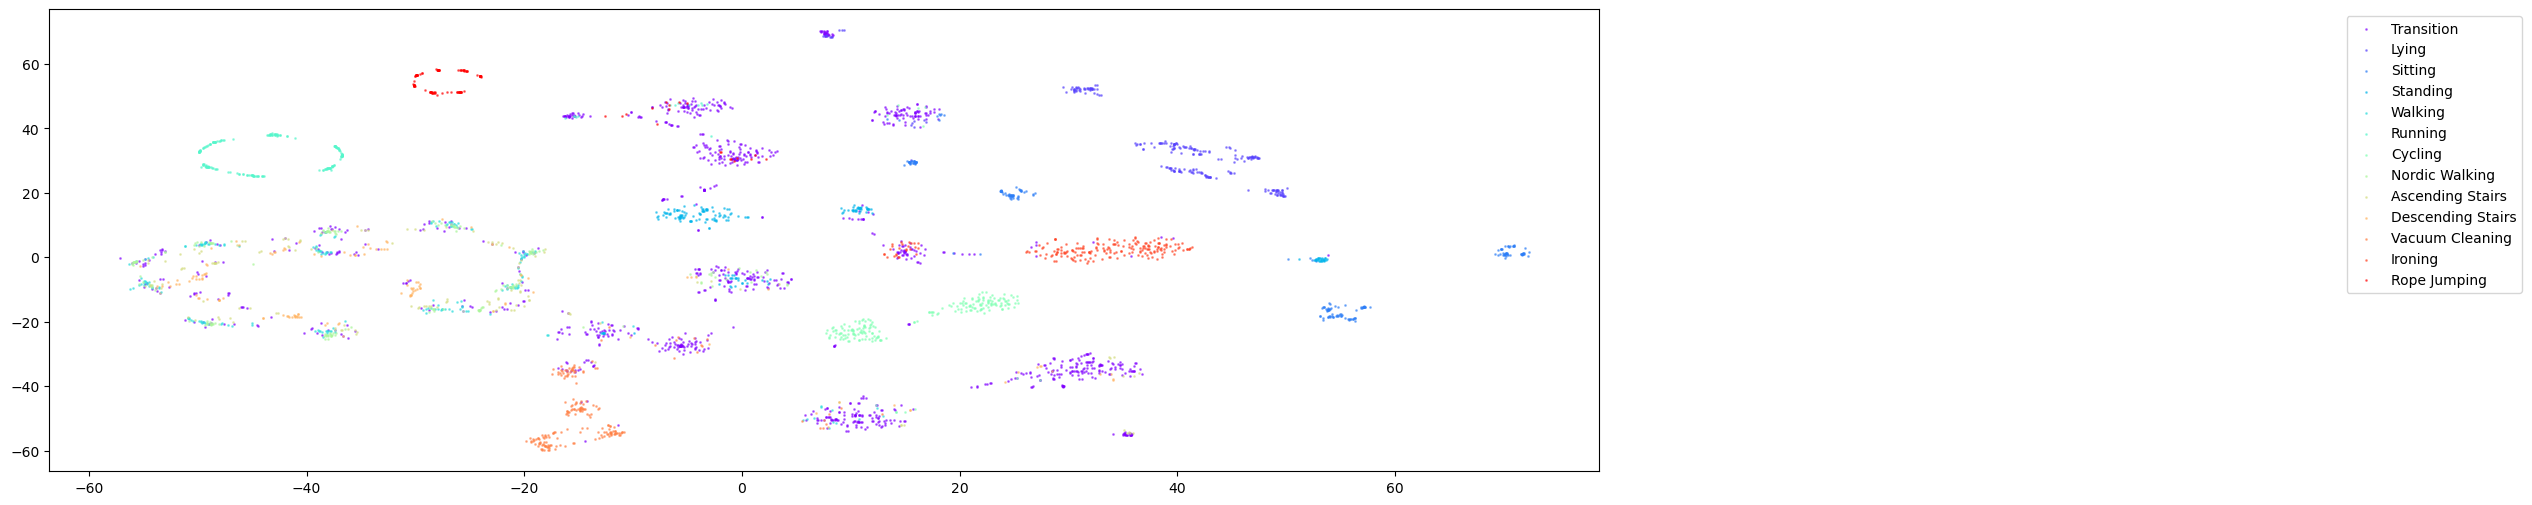

In [58]:
clustering_output = []
for ts in data_loader:
    recon = deep_cluster_model.AE.encode((ts.float().to(device)))
    clustering_output.append( recon.cpu().detach().numpy() ) 
    

clustering_output = [item for sublist in clustering_output for item in sublist]

clustering_output = np.asarray(clustering_output)
clustering_output_f = []
for i,co in enumerate(clustering_output):
    clustering_output[i].flatten()
    clustering_output_f.append(clustering_output[i].flatten())
clustering_output_f = np.asarray(clustering_output_f)

activities = []
activities.append(labels[0])
for l in labels:
    if l != activities[-1]:
        activities.append(int(l))


activity_names = ['Transition',
                  'Lying',
                  'Sitting',
                  'Standing',
                  'Walking',
                  'Running',
                  'Cycling',
                  'Nordic Walking',
                  '8',
                  'Watching TV',
                  'Computer Work',
                  'Car Driving',
                  'Ascending Stairs',
                  'Descending Stairs',
                  '14',
                  '15',
                  'Vacuum Cleaning',
                  'Ironing',
                  'Folding Laundry',
                  'House Cleaning',
                  'Playing Soccer',
                  '21',
                  '22',
                  '23',
                  'Rope Jumping']

X_embedded = TSNE(n_components=2).fit_transform(clustering_output_f)

cmap = plt.get_cmap('rainbow')

l = np.unique(labels)
slicedCM = cmap(np.linspace(0, 1, len(l))) 



for m,la in enumerate(l): 
    ind = np.where(subsequence_labels==la)
    plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color=slicedCM[m], label=activity_names[int(la)], alpha=0.5, s=1)

plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0))

## Remove Duplicate Cluster Labels and Set Labels in Sequential Order

In [60]:
while ( (not all(l[i] == l[i+1] -1 for i in range(len(l) - 1))) or (l[0] != 0) ):
    for assignment in range(np.max(cluster_assignments)+1):
        if assignment not in cluster_assignments:
            indx = np.where(cluster_assignments > assignment)
            cluster_assignments[indx] = cluster_assignments[indx]-1
    l = np.unique(cluster_assignments)

## Phase 3: Sldiing Window on Cluster Labels

In [97]:
window_length2 = 50

similarities = get_label_score(cluster_assignments, window_length2)


## Normalize and Smooth Sliding Window Distance

In [98]:
data = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
data = smooth(np.blackman(55), data)

In [99]:
peaks, peak_data = find_peaks(data, height=0.5,distance=window_length2//3,prominence=0.08)
real_peaks = peaks+window_length2//2
predictions = get_changepoints(real_peaks, window_length, overlap_percent)


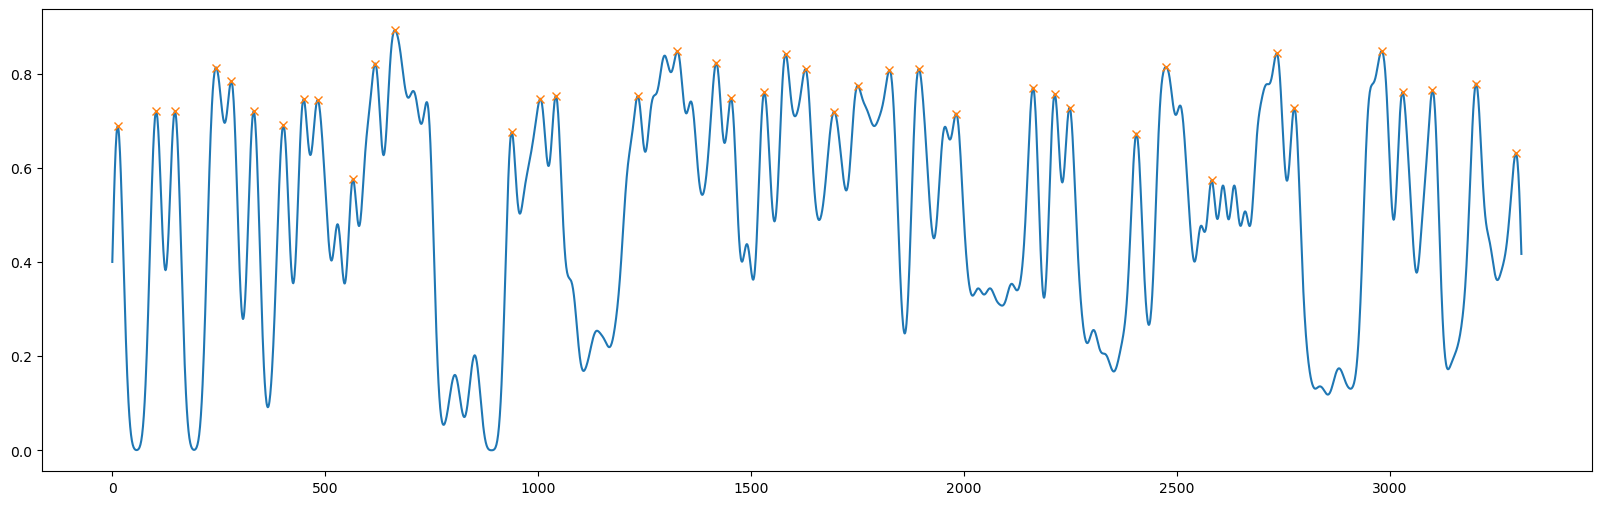

Space: Encoded Hidden Space
Clusters = 70


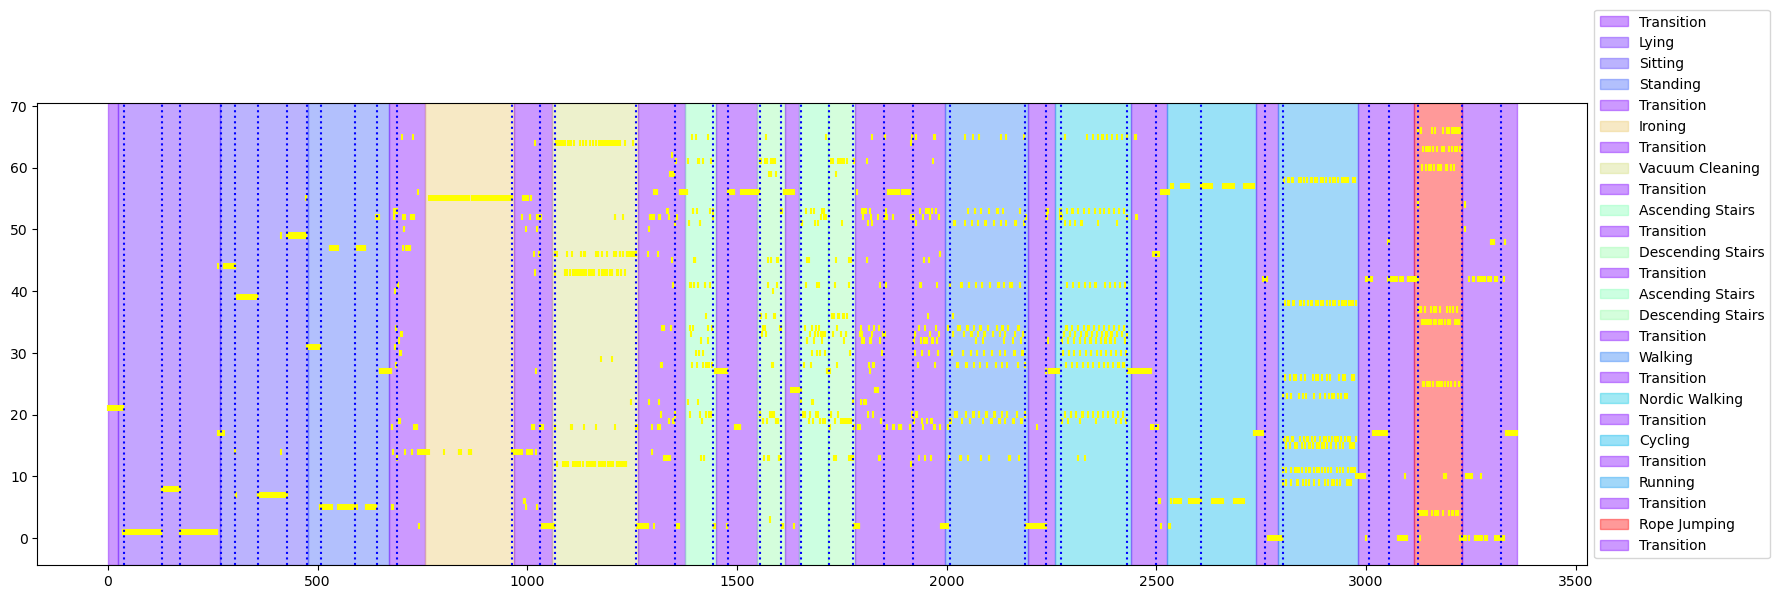

covering score: 0.6345178391303911
margin: 3000
f_measure score: (0.7164179104477613, 0.5853658536585366, 0.9230769230769231)


In [100]:
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
cmap = plt.get_cmap('rainbow')

l = np.unique(labels)


slicedCM = cmap(np.linspace(0, 1, len(activity_names))) 


plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.show()

positions = np.arange(len(cluster_assignments))[:,np.newaxis]

plt.eventplot(positions, lineoffsets=cluster_assignments, color = [(1.0,1.0,0.0)])

for vline in real_peaks:
    plt.axvline(x = vline, color = 'b', linestyle=':', mfc='b')

start = 0
subsequence_ground_truth = np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]
print("Space: Encoded Hidden Space\nClusters = {}".format(n_clusters))
for i, activity in enumerate(activities):
    if i == len(activities):
        continue
    if i == len(activities)-1:
        end = len(subsequence_labels)
    else:
        end = subsequence_ground_truth[i]

    plt.axvspan(start, end, alpha=0.4, color=slicedCM[int(activity)], label=activity_names[int(activity)])
    plt.legend(loc=3, bbox_to_anchor=(1, 0, 0, 1.0))
    start = end
plt.show()

print('covering score:',covering(ground_truth, predictions, len(labels)))
margin = 100*30
print('margin:',margin)
print('f_measure score:',f_measure(ground_truth, predictions, margin=margin, alpha=0.5, return_PR=True))